# Задача классификации рукописных цифр

In [1]:
import numpy
import time
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import sklearn.metrics

import math

import tensorflow

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

c:\users\stas\envs\data_science\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Загрузка данных

In [2]:
digits = sklearn.datasets.load_digits()
data = digits['data']
labels = digits['target']

In [3]:
len(data), len(data[0]), min([min(v) for v in data]), max([max(v) for v in data])

(1797, 64, 0.0, 16.0)

In [4]:
labels, sorted(set(labels)), len(labels)

(array([0, 1, 2, ..., 8, 9, 8]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1797)

Итак, в размеченном наборе данных всего 1797 цифр, каждая представлена одномерным массивом из 64 элементов (8x8 пикселей).
Так они выглядят (первые 50 изображений).

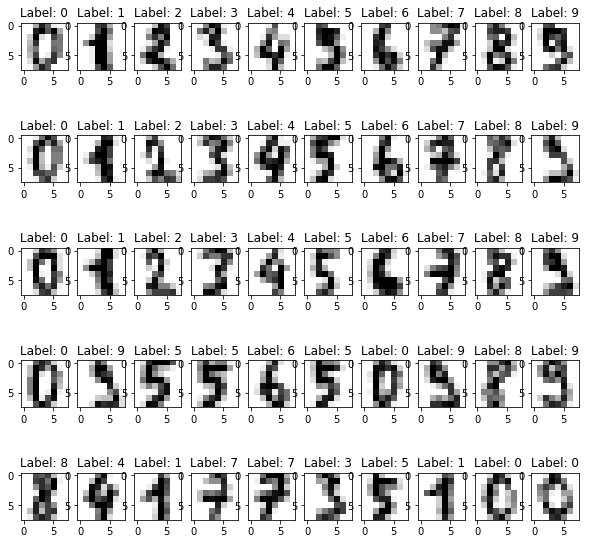

In [5]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Label: {labels[i]}')

## 2. Создаем самую простую нейронную сеть прямого распространения с обычными связанными слоями

In [6]:
model = Sequential()

model.add(Dense(64, input_dim=64, activation="relu", kernel_initializer="normal"))
model.add(Dense(10, activation="softmax", kernel_initializer="normal"))

model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 4,810
Trainable params: 4,810
Non-trainable params: 0
_________________________________________________________________
None


## 3. Тренируем сеть

In [7]:
labelled_output = list()
for l in labels:
    tmp = [0] * 10
    tmp[l] = 1
    labelled_output.append(tmp)

In [8]:
model.fit(data, numpy.array(labelled_output), batch_size=200, epochs=100, validation_split=0.2, verbose=2)

Train on 1437 samples, validate on 360 samples
Epoch 1/100
 - 0s - loss: 2.2717 - acc: 0.1823 - val_loss: 1.9646 - val_acc: 0.3944
Epoch 2/100
 - 0s - loss: 1.8063 - acc: 0.5129 - val_loss: 1.5973 - val_acc: 0.6417
Epoch 3/100
 - 0s - loss: 1.4411 - acc: 0.7370 - val_loss: 1.3061 - val_acc: 0.7528
Epoch 4/100
 - 0s - loss: 1.1528 - acc: 0.8330 - val_loss: 1.1027 - val_acc: 0.7667
Epoch 5/100
 - 0s - loss: 0.9303 - acc: 0.8622 - val_loss: 0.9452 - val_acc: 0.7889
Epoch 6/100
 - 0s - loss: 0.7596 - acc: 0.8984 - val_loss: 0.8005 - val_acc: 0.8167
Epoch 7/100
 - 0s - loss: 0.6324 - acc: 0.9165 - val_loss: 0.7218 - val_acc: 0.8472
Epoch 8/100
 - 0s - loss: 0.5401 - acc: 0.9228 - val_loss: 0.6478 - val_acc: 0.8556
Epoch 9/100
 - 0s - loss: 0.4725 - acc: 0.9311 - val_loss: 0.5937 - val_acc: 0.8528
Epoch 10/100
 - 0s - loss: 0.4181 - acc: 0.9367 - val_loss: 0.5596 - val_acc: 0.8639
Epoch 11/100
 - 0s - loss: 0.3789 - acc: 0.9402 - val_loss: 0.5421 - val_acc: 0.8556
Epoch 12/100
 - 0s - loss: 

Epoch 97/100
 - 0s - loss: 0.0533 - acc: 0.9896 - val_loss: 0.3239 - val_acc: 0.9111
Epoch 98/100
 - 0s - loss: 0.0532 - acc: 0.9896 - val_loss: 0.3126 - val_acc: 0.9167
Epoch 99/100
 - 0s - loss: 0.0528 - acc: 0.9916 - val_loss: 0.3195 - val_acc: 0.9167
Epoch 100/100
 - 0s - loss: 0.0517 - acc: 0.9916 - val_loss: 0.3288 - val_acc: 0.9111


## 4. Тестовая картинка

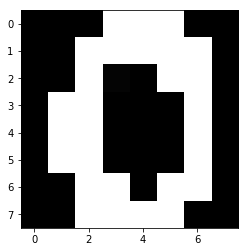

In [9]:
img = plt.imread('0_small.png')
plt.imshow(img, cmap='gray')

In [10]:
len(img), len(img[0]), len(img[0][0])

(8, 8, 3)

Видно, что загруженная PNG картинка устроена по-другому, не так как тестовый набор digits в sklearn: это двумерный массив 8x8, каждый элемент которого это RGB-тройка, причем компоненты RGB - это числа с плавающей точкой от 0 до 1. А sklearn.datasets.load_digits() возвращает пиксели как число от 0 до 16 (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Таким образом, нам надо свернуть (R,G,B) в одно число с максимальным значением 16. Сделаем это, например, так:

In [11]:
transformed_img = list()
for line in img:
    for pixel in line:
        com_r = pixel[0]
        com_g = pixel[1]
        com_b = pixel[2]
        transformed_img.append(int(math.sqrt(com_r**2 + com_g**2 + com_b**2) * 16 / math.sqrt(3)))
numpy.array(transformed_img).shape

(64,)

In [12]:
[round(x, 3) for x in model.predict(numpy.array([transformed_img]))[0]]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Таким образом, это - __0__.